<a href="https://colab.research.google.com/github/apssouza22/cnn-for-devs/blob/master/f-image-interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image interpolation with Autoencoders
======


We are going to learn how to work with autoencoders to generate Latent Space/ feature map and from there do some nice things

Autoencoder Definition
-----------------------
AutoEncoder is an unsupervised Artificial Neural Network that attempts to encode the data by compressing it into the lower dimensions(dimensionality reduction) and then decoding the data to reconstruct the original input.

<img src="https://miro.medium.com/max/700/1*AJ_zWZundfZ2-11eZUw5GA.png">

In [1]:
%matplotlib inline
import os
import natsort


import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from PIL import Image
from torchvision.transforms.functional import resize, to_tensor, normalize, to_pil_image

import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils

from torchvision.utils import make_grid


Parameter Settings
-------------------


In [3]:
num_classes = 1
num_epochs = 40
batch_size = 128
learning_rate = 0.001
use_gpu = True
img_size = 64#288


MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

In [4]:
def prep_img(image: str, size=img_size, mean=(0.5,), std=(0.5,)):
   
    im = Image.open(image)
    image_prepared = resize(im, size)
    image_prepared = image_prepared.convert('L')
    image_prep_tensor = to_tensor(image_prepared).unsqueeze(0)
    image_prep_tensor = normalize(image_prep_tensor, mean=mean, std=std)
    return image_prep_tensor

In [5]:
path = './capture/'
# file_list = os.listdir(path)
file_list = natsort.natsorted(os.listdir(path))
print(file_list)

Images = []
for file_name in file_list:
    IMG_PATH = path+file_name
    # print(IMG_PATH)
    # Take a look
    #texture = Image.open(BytesIO(urlopen(IMG).read()))
    # tmp_img= Image.open(IMG_PATH) # 이미지 파일 메타 정보 확인 -> 이미지 객체 반환
    # tmp_img = tmp_img.convert('L')
    # tmp_img = np.array(tmp_img)
    Images.append(prep_img(IMG_PATH))
print(len(Images))

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
# full_dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)


['draw-0.bmp', 'draw-3.bmp', 'draw-6.bmp', 'draw-9.bmp', 'draw-12.bmp', 'draw-15.bmp', 'draw-18.bmp', 'draw-21.bmp', 'draw-24.bmp', 'draw-27.bmp', 'draw-30.bmp', 'draw-33.bmp', 'draw-36.bmp', 'draw-39.bmp', 'draw-42.bmp', 'draw-45.bmp', 'draw-48.bmp', 'draw-51.bmp', 'draw-54.bmp', 'draw-57.bmp', 'draw-60.bmp', 'draw-63.bmp', 'draw-66.bmp', 'draw-69.bmp', 'draw-72.bmp', 'draw-75.bmp', 'draw-78.bmp', 'draw-81.bmp', 'draw-84.bmp', 'draw-87.bmp', 'draw-90.bmp', 'draw-93.bmp', 'draw-96.bmp', 'draw-99.bmp', 'draw-102.bmp', 'draw-105.bmp', 'draw-108.bmp', 'draw-111.bmp', 'draw-114.bmp', 'draw-117.bmp', 'draw-120.bmp', 'draw-123.bmp', 'draw-126.bmp', 'draw-129.bmp', 'draw-132.bmp', 'draw-135.bmp', 'draw-138.bmp', 'draw-141.bmp', 'draw-144.bmp', 'draw-147.bmp', 'draw-150.bmp', 'draw-153.bmp', 'draw-156.bmp', 'draw-159.bmp', 'draw-162.bmp', 'draw-165.bmp', 'draw-168.bmp', 'draw-171.bmp', 'draw-174.bmp', 'draw-177.bmp', 'draw-180.bmp', 'draw-183.bmp', 'draw-186.bmp', 'draw-189.bmp', 'draw-192.bmp

Autoencoder consists of an Encoder and a Decoder model

In [6]:
# # Model responsible for generating our Latent space.
# #Latent space, Typically it is a 100-dimensional hypersphere with each variable drawn from a Gaussian distribution with a mean of zero and a standard deviation of one
# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=img_size, kernel_size=4, stride=2, padding=1) # out: 이미지 사이즈 반토막 c x 14 x 14
#         self.conv2 = nn.Conv2d(in_channels=img_size, out_channels=img_size*2, kernel_size=4, stride=2, padding=1) # out: 이미지 사이즈 반토막 c x 7 x 7
#         # self.fc = nn.Linear(in_features=((img_size * 2) -4+(2*1))//2+1, out_features=num_classes)
#         self.fc = nn.Linear(in_features=img_size * 2 * (img_size//(2*2)) * (img_size//(2*2)), out_features=num_classes)
#         # outputsize = (inputsize-kernelsize+2padingsize)/stride+1

            
#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
#         x = self.fc(x)
#         return x

# # Model responsible for reconstruct the image form our Latent space.
# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.fc = nn.Linear(in_features=num_classes, out_features=img_size * 2 * (img_size//(2*2)) * (img_size//(2*2)))    
#         self.conv2 = nn.ConvTranspose2d(in_channels=img_size * 2, out_channels=img_size, kernel_size=4, stride=2, padding=1)
#         self.conv1 = nn.ConvTranspose2d(in_channels=img_size, out_channels=1, kernel_size=4, stride=2, padding=1)
#         # outputsize = (imagesize-kernelsize)/stride+1
            
#     def forward(self, x):
#         x = self.fc(x)
#         x = x.view(x.size(0), img_size * 2, (img_size//(2*2)), (img_size//(2*2))) # unflatten batch of feature vectors to a batch of multi-channel feature maps
#         x = F.relu(self.conv2(x))
#         x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
#         return x
    
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = Encoder()
#         self.decoder = Decoder()
    
#     def forward(self, x):
#         latent = self.encoder(x)
#         x_recon = self.decoder(latent)
#         return x_recon
    
# autoencoder = Autoencoder()

# device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
# autoencoder = autoencoder.to(device)

# #The model’s parameters that need to be trained.
# num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
# print('Number of parameters: %d' % num_params)

In [7]:
# # Model responsible for generating our Latent space.
# #Latent space, Typically it is a 100-dimensional hypersphere with each variable drawn from a Gaussian distribution with a mean of zero and a standard deviation of one
# class Encoder(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # Convolution, Batch Normalization, ReLU 연산을 합친 함수
#         def CBR2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1):
#             layer = nn.Sequential(
#                 nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride, padding=padding),
#                 nn.BatchNorm2d(num_features=output_channel),
#                 nn.ReLU()
                
#             )
#             return layer

#         # Down Path ######################
#         # Contracting path
#         # conv 기본적으로 kernel size 3*3 에 stride 1으로 ■■■□□□ □■■■□□ □□■■■□ □□□■■■ =>2칸씩 크기가 줄어든다
#         # 256x256x3 => 256x256x32
#         self.conv1 = nn.Sequential(
#             CBR2d(input_channel=1, output_channel=32),
#             CBR2d(32, 32)
#         )
#         # 256x256x32 => 128x128x32
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

#         # 128x128x32 => 128x128x64
#         self.conv2 = nn.Sequential(
#             CBR2d(32, 64),
#             CBR2d(64, 64)
#         )
#         # 128x128x64 => 64x64x64
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

#         # 64x64x64 => 64x64x128
#         self.conv3 = nn.Sequential(
#             CBR2d(64, 128),
#             CBR2d(128, 128)
#         )
#         # 64x64x128 => 32x32x128
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

#         # 32x32x128 => 32x32x256
#         # Contracting path 마지막에 Dropout 적용
#         self.conv4 = nn.Sequential(
#             CBR2d(128, 256),
#             CBR2d(256, 256),
#             nn.Dropout(p=0.5)
#         )
#         # 32x32x256 => 16x16x256
#         self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
#         # Contracting path 끝
#         ###################################

#         # Bottlneck 구간 #########512###########
#         # 16x16x256 => 16x16x512
#         self.bottleNeck = nn.Sequential(
#             CBR2d(256, 512),
#             CBR2d(512, 512),
#         )
#         # Bottlneck 구간 끝
#         ###################################

#     def forward(self, x):
#         # Contracting path
#         # 572x572x1 => 568x568x64
#         layer1 = self.conv1(x)

#         # Max Pooling
#         # 568x568x64 => 284x284x64
#         out = self.pool1(layer1)

#         # 284x284x64 => 280x280x128
#         layer2 = self.conv2(out)

#         # Max Pooling
#         # 280x280x128 => 140x140x128
#         out = self.pool2(layer2)

#         # 140x140x128 => 136x136x256
#         layer3 = self.conv3(out)

#         # Max Pooling
#         # 136x136x256 => 68x68x256
#         out = self.pool3(layer3)

#         # 68x68x256 => 64x64x512
#         layer4 = self.conv4(out)

#         # Max Pooling
#         # 64x64x512 => 32x32x512
#         out = self.pool4(layer4)

#         # bottleneck
#         # 32x32x512 => 28x28x1024
#         bottleNeck = self.bottleNeck(out)

#         return layer1, layer2, layer3, layer4, bottleNeck

# # Model responsible for reconstruct the image form our Latent space.
# class Decoder(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # Convolution, Batch Normalization, ReLU 연산을 합친 함수
#         def CBR2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1):
#             layer = nn.Sequential(
#                 nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride, padding=padding),
#                 nn.BatchNorm2d(num_features=output_channel),
#                 nn.ReLU()
#             )
#             return layer

#         # Up Path #########################
#         # Expanding path
#         # channel 수를 감소 시키며 Up-Convolution
#         # 16x16x512 => 32x32x256
#         self.upconv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)

#         # Up-Convolution 이후 channel = 256
#         # Contracting path 중 같은 단계의 Feature map을 가져와 Up-Convolution 결과의 Feature map과 Concat 연산
#         # => channel = 512 가 됩니다.
#         # forward 부분을 참고해주세요
#         # 32x32x512 => 32x32x256
#         self.ex_conv1 = nn.Sequential(
#             CBR2d(512, 256),
#             CBR2d(256, 256)
#         )

#         # 32x32x256 => 64x64x128
#         self.upconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)

#         # 64x64x256 => 64x64x128
#         self.ex_conv2 = nn.Sequential(
#             CBR2d(256, 128),
#             CBR2d(128, 128)
#         )

#         # 64x64x128 => 128x128x64
#         self.upconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

#         # 128x128x128 => 128x128x64
#         self.ex_conv3 = nn.Sequential(
#             CBR2d(128, 64),
#             CBR2d(64, 64)
#         )

#         # 128x128x64 => 256x256x32
#         self.upconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)

#         # 256x256x64 => 256x256x32
#         self.ex_conv4 = nn.Sequential(
#             CBR2d(64, 32),
#             CBR2d(32, 32),

#         )

#         # 논문 구조상 output = 2 channel
#         # train 데이터에서 세포 / 배경을 검출하는것이 목표여서 class_num = 1로 지정
#         # 256x256x32 => 256x256x1
#         self.fc = nn.Conv2d(32, num_classes, kernel_size=1, stride=1)
        
#     def forward(self, x, layer1, layer2, layer3, layer4):
#         # Expanding path
#         # 28x28x1024 => 56x56x512
#         upconv1 = self.upconv1(x)

#         # Contracting path 중 같은 단계의 Feature map을 가져와 합침
#         # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
#         # 56x56x512 => 56x56x1024
#         cat1 = torch.cat((transforms.CenterCrop((upconv1.shape[2], upconv1.shape[3]))(layer4), upconv1), dim=1)
#         # 레이어 4를 중간 기준으로 upconv1 의 h(upconv1.shape[2]),w(upconv1.shape[3]) 만큼 잘라서 □■ 나란히 연결

#         # 56x56x1024 => 52x52x512
#         ex_layer1 = self.ex_conv1(cat1)

#         # 52x52x512 => 104x104x256
#         upconv2 = self.upconv2(ex_layer1)

#         # Contracting path 중 같은 단계의 Feature map을 가져와 합침
#         # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
#         # 104x104x256 => 104x104x512
#         cat2 = torch.cat((transforms.CenterCrop((upconv2.shape[2], upconv2.shape[3]))(layer3), upconv2), dim=1)
#         # 레이어 3를 중간 기준으로 upconv2 의 h(upconv2.shape[2]),w(upconv2.shape[3]) 만큼 잘라서 □■ 나란히 연결

#         # 104x104x512 => 100x100x256
#         ex_layer2 = self.ex_conv2(cat2)

#         # 100x100x256 => 200x200x128
#         upconv3 = self.upconv3(ex_layer2)

#         # Contracting path 중 같은 단계의 Feature map을 가져와 합침
#         # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
#         # 200x200x128 => 200x200x256
#         cat3 = torch.cat((transforms.CenterCrop((upconv3.shape[2], upconv3.shape[3]))(layer2), upconv3), dim=1)
#         # 레이어 2를 중간 기준으로 upconv3 의 h(upconv3.shape[2]),w(upconv3.shape[3]) 만큼 잘라서 □■ 나란히 연결

#         # 200x200x256 => 196x196x128
#         ex_layer3 = self.ex_conv3(cat3)

#         # 196x196x128=> 392x392x64
#         upconv4 = self.upconv4(ex_layer3)

#         # Contracting path 중 같은 단계의 Feature map을 가져와 합침
#         # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
#         # 392x392x64 => 392x392x128
#         cat4 = torch.cat((transforms.CenterCrop((upconv4.shape[2], upconv4.shape[3]))(layer1), upconv4), dim=1)
#         # 레이어 1를 중간 기준으로 upconv4 의 h(upconv4.shape[2]),w(upconv4.shape[3]) 만큼 잘라서 □■ 나란히 연결

#         # 392x392x128 => 388x388x64
#         out = self.ex_conv4(cat4)

#         # 388x388x64 => 388x388x1
#         out = self.fc(out)
#         out = F.relu(out)
#         out = torch.tanh(out) # last layer before output is tanh, since the images are normalized and 0-centered
#         return out
    
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = Encoder()
#         self.decoder = Decoder()
    
#     def forward(self, x):
#         layer1, layer2, layer3, layer4, latent = self.encoder(x)
#         x_recon = self.decoder(latent, layer1, layer2, layer3, layer4)
#         return x_recon
    
# autoencoder = Autoencoder()

# device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
# autoencoder = autoencoder.to(device)

# #The model’s parameters that need to be trained.
# num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
# print('Number of parameters: %d' % num_params)

# # autoencoder = Autoencoder()

# # device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
# # autoencoder = autoencoder.to(device)

# # #The model’s parameters that need to be trained.
# # num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
# # print('Number of parameters: %d' % num_params)

In [8]:
# Model responsible for generating our Latent space.
#Latent space, Typically it is a 100-dimensional hypersphere with each variable drawn from a Gaussian distribution with a mean of zero and a standard deviation of one
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution, Batch Normalization, ReLU 연산을 합친 함수
        def CBR2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1):
            layer = nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(num_features=output_channel),
                nn.ReLU()
                
            )
            return layer

        # Down Path ######################
        # Contracting path
        # conv 기본적으로 kernel size 3*3 에 stride 1으로 ■■■□□□ □■■■□□ □□■■■□ □□□■■■ =>2칸씩 크기가 줄어든다
        # 256x256x3 => 256x256x32
        self.conv1 = nn.Sequential(
            CBR2d(input_channel=1, output_channel=32),
            CBR2d(32, 32)
        )
        # 256x256x32 => 128x128x32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 128x128x32 => 128x128x64
        self.conv2 = nn.Sequential(
            CBR2d(32, 64),
            CBR2d(64, 64)
        )
        # 128x128x64 => 64x64x64
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 64x64x64 => 64x64x128
        self.conv3 = nn.Sequential(
            CBR2d(64, 128),
            CBR2d(128, 128)
        )
        # 64x64x128 => 32x32x128
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 32x32x128 => 32x32x256
        # Contracting path 마지막에 Dropout 적용
        self.conv4 = nn.Sequential(
            CBR2d(128, 256),
            CBR2d(256, 256),
            nn.Dropout(p=0.5)
        )
        # 32x32x256 => 16x16x256
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path 끝
        ###################################

        # Bottlneck 구간 #########512###########
        # 16x16x256 => 16x16x512
        self.bottleNeck = nn.Sequential(
            CBR2d(64, 128),
            CBR2d(128, 128),
        )
        # Bottlneck 구간 끝
        ###################################

    def forward(self, x):
        # Contracting path
        # 572x572x1 => 568x568x64
        layer1 = self.conv1(x)

        # Max Pooling
        # 568x568x64 => 284x284x64
        out = self.pool1(layer1)

        # 284x284x64 => 280x280x128
        layer2 = self.conv2(out)

        # Max Pooling
        # 280x280x128 => 140x140x128
        out = self.pool2(layer2)

        # # 140x140x128 => 136x136x256
        # layer3 = self.conv3(out)

        # # Max Pooling
        # # 136x136x256 => 68x68x256
        # out = self.pool3(layer3)

        # # 68x68x256 => 64x64x512
        # layer4 = self.conv4(out)

        # # Max Pooling
        # # 64x64x512 => 32x32x512
        # out = self.pool4(layer4)

        # bottleneck
        # 32x32x512 => 28x28x1024
        bottleNeck = self.bottleNeck(out)

        return layer1, layer2, bottleNeck

# Model responsible for reconstruct the image form our Latent space.
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution, Batch Normalization, ReLU 연산을 합친 함수
        def CBR2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1):
            layer = nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(num_features=output_channel),
                nn.ReLU()
            )
            return layer

        # Up Path #########################
        # Expanding path
        # channel 수를 감소 시키며 Up-Convolution
        # 16x16x512 => 32x32x256
        self.upconv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

        # Up-Convolution 이후 channel = 256
        # Contracting path 중 같은 단계의 Feature map을 가져와 Up-Convolution 결과의 Feature map과 Concat 연산
        # => channel = 512 가 됩니다.
        # forward 부분을 참고해주세요
        # 32x32x512 => 32x32x256
        self.ex_conv1 = nn.Sequential(
            CBR2d(128, 64),
            CBR2d(64, 64)
        )

        # 32x32x256 => 64x64x128
        self.upconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)

        # 64x64x256 => 64x64x128
        self.ex_conv2 = nn.Sequential(
            CBR2d(64, 32),
            CBR2d(32, 32)
        )

        # 64x64x128 => 128x128x64
        self.upconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

        # 128x128x128 => 128x128x64
        self.ex_conv3 = nn.Sequential(
            CBR2d(128, 64),
            CBR2d(64, 64)
        )

        # 128x128x64 => 256x256x32
        self.upconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)

        # 256x256x64 => 256x256x32
        self.ex_conv4 = nn.Sequential(
            CBR2d(64, 32),
            CBR2d(32, 32),

        )

        self.upconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2)

        # 논문 구조상 output = 2 channel
        # train 데이터에서 세포 / 배경을 검출하는것이 목표여서 class_num = 1로 지정
        # 256x256x32 => 256x256x1
        self.fc = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        
    def forward(self, x, layer3, layer4):
        # Expanding path
        # 28x28x1024 => 56x56x512
        upconv1 = self.upconv1(x)

        # Contracting path 중 같은 단계의 Feature map을 가져와 합침
        # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
        # 56x56x512 => 56x56x1024
        cat1 = torch.cat((transforms.CenterCrop((upconv1.shape[2], upconv1.shape[3]))(layer4), upconv1), dim=1)
        # 레이어 4를 중간 기준으로 upconv1 의 h(upconv1.shape[2]),w(upconv1.shape[3]) 만큼 잘라서 □■ 나란히 연결

        # 56x56x1024 => 52x52x512
        ex_layer1 = self.ex_conv1(cat1)

        # 52x52x512 => 104x104x256
        upconv2 = self.upconv2(ex_layer1)

        # Contracting path 중 같은 단계의 Feature map을 가져와 합침
        # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
        # 104x104x256 => 104x104x512
        cat2 = torch.cat((transforms.CenterCrop((upconv2.shape[2], upconv2.shape[3]))(layer3), upconv2), dim=1)
        # 레이어 3를 중간 기준으로 upconv2 의 h(upconv2.shape[2]),w(upconv2.shape[3]) 만큼 잘라서 □■ 나란히 연결

        # 104x104x512 => 100x100x256
        out = self.ex_conv2(cat2)

        # # 100x100x256 => 200x200x128
        # upconv3 = self.upconv3(ex_layer2)

        # # Contracting path 중 같은 단계의 Feature map을 가져와 합침
        # # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
        # # 200x200x128 => 200x200x256
        # cat3 = torch.cat((transforms.CenterCrop((upconv3.shape[2], upconv3.shape[3]))(layer2), upconv3), dim=1)
        # # 레이어 2를 중간 기준으로 upconv3 의 h(upconv3.shape[2]),w(upconv3.shape[3]) 만큼 잘라서 □■ 나란히 연결

        # # 200x200x256 => 196x196x128
        # ex_layer3 = self.ex_conv3(cat3)

        # # 196x196x128=> 392x392x64
        # upconv4 = self.upconv4(ex_layer3)

        # # Contracting path 중 같은 단계의 Feature map을 가져와 합침
        # # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
        # # 392x392x64 => 392x392x128
        # cat4 = torch.cat((transforms.CenterCrop((upconv4.shape[2], upconv4.shape[3]))(layer1), upconv4), dim=1)
        # # 레이어 1를 중간 기준으로 upconv4 의 h(upconv4.shape[2]),w(upconv4.shape[3]) 만큼 잘라서 □■ 나란히 연결

        # # 392x392x128 => 388x388x64
        # ex_layer4 = self.ex_conv4(cat4)

        # out = self.upconv5(ex_layer4)
        # self.upconv5

        # 388x388x64 => 388x388x1
        out = self.fc(out)
        out = F.relu(out)
        out = torch.tanh(out) # last layer before output is tanh, since the images are normalized and 0-centered
        return out
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        layer1, layer2, latent = self.encoder(x)
        x_recon = self.decoder(latent, layer1, layer2)
        return x_recon
    
autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

#The model’s parameters that need to be trained.
num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

# autoencoder = Autoencoder()

# device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
# autoencoder = autoencoder.to(device)

# #The model’s parameters that need to be trained.
# num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
# print('Number of parameters: %d' % num_params)

Number of parameters: 1757393


Train Autoencoder
--------

In [9]:
if not os.path.exists("assets"):
    os.mkdir("assets")

ENCODER_MODEL_PATH="assets/encoder.pth"
DECODER_MODEL_PATH="assets/decoder.pth"
AUTOENCODER_MODEL_PATH="assets/autoencoder.pth"

optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch in Images: # dataloader : dictionary : {image: , label: }
        image_batch = image_batch.to(device)
        image_batch_recon = autoencoder(image_batch)
        # print(image_batch.shape)
        # print(image_batch_recon.shape)
      
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    torch.save(autoencoder.encoder.state_dict(), ENCODER_MODEL_PATH)
    torch.save(autoencoder.decoder.state_dict(), DECODER_MODEL_PATH)
    torch.save(autoencoder.state_dict(), AUTOENCODER_MODEL_PATH)

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 40] average reconstruction error: 0.850487
Epoch [2 / 40] average reconstruction error: 0.850896
Epoch [3 / 40] average reconstruction error: 0.849167
Epoch [4 / 40] average reconstruction error: 0.848800
Epoch [5 / 40] average reconstruction error: 0.848395
Epoch [6 / 40] average reconstruction error: 0.848356
Epoch [7 / 40] average reconstruction error: 0.848226
Epoch [8 / 40] average reconstruction error: 0.848379
Epoch [9 / 40] average reconstruction error: 0.848188
Epoch [10 / 40] average reconstruction error: 0.848138
Epoch [11 / 40] average reconstruction error: 0.848092
Epoch [12 / 40] average reconstruction error: 0.848025
Epoch [13 / 40] average reconstruction error: 0.848001
Epoch [14 / 40] average reconstruction error: 0.847979
Epoch [15 / 40] average reconstruction error: 0.847951
Epoch [16 / 40] average reconstruction error: 0.847937
Epoch [17 / 40] average reconstruction error: 0.847988
Epoch [18 / 40] average reconstruction error: 0.848057
Epoch 

Plot Training Curve
--------------------

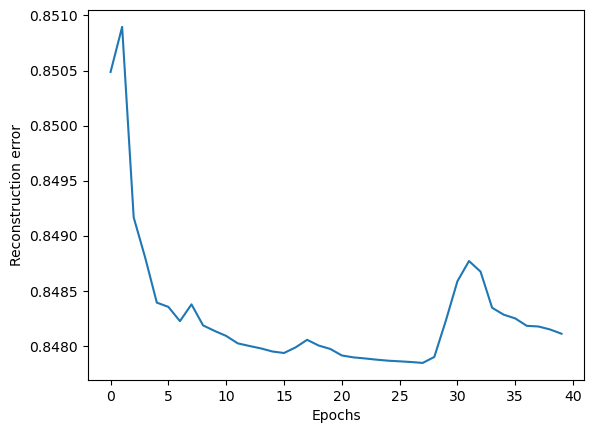

In [10]:
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

Evaluate on the Test Set
-------------------------

In [11]:
# # model = torch.load(AUTOENCODER_MODEL_PATH)
# # model = autoencoder(self.args)
# # model.load_state_dict(torch.load(AUTOENCODER_MODEL_PATH))
# # model.eval()

# # set to evaluation mode
# autoencoder.eval()    #orig : autoencoder.

# test_loss_avg, num_batches = 0, 0
# for image_batch, _ in test_dataloader:
#     with torch.no_grad():

#         image_batch = image_batch.to(device)

#         # autoencoder reconstruction
#         image_batch_recon = autoencoder(image_batch)  #orig : autoencoder.

#         # reconstruction error
#         loss = F.mse_loss(image_batch_recon, image_batch)

#         test_loss_avg += loss.item()
#         num_batches += 1
    
# test_loss_avg /= num_batches
# print('average reconstruction error: %f' % (test_loss_avg))

In [12]:
plt.ion()

num_img_start = 0
num_img_end = 50

# Util function to display the images
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    npimg = npimg.squeeze(0)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def org_output(images):
    grid_img = []
    for i, img in enumerate(images):
        img = to_img(img).squeeze(0)
        grid_img.append(img)

    np_imagegrid = torchvision.utils.make_grid(grid_img[num_img_start:num_img_end], 10).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

def visualise_output(images, model):
    with torch.no_grad():

        grid_img = []
        for i, img in enumerate(images):
            img = img.to(device)
            img = model(img)
            img = img.cpu()
            img = to_img(img).squeeze(0)
            grid_img.append(img)
        print(len(grid_img))
        print(grid_img[0].shape)

        # grid = make_grid(images, nrow=10)
        # images = images.to(device)
        # images = model(images)
        # images = images.cpu()
        # images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(grid_img[num_img_start:num_img_end], 10).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()


Visualize Reconstructions
--------------------------

Original images


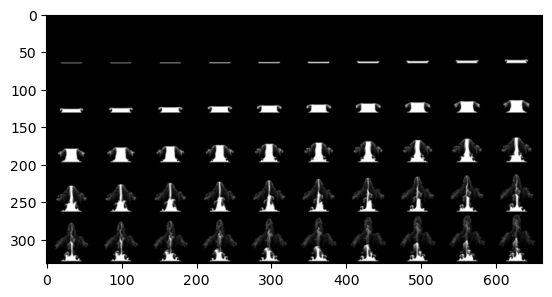

Autoencoder reconstruction:
141
torch.Size([1, 64, 64])


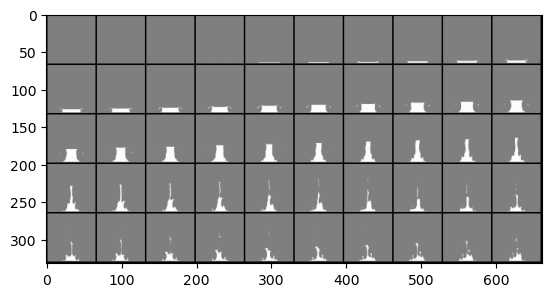

In [13]:
autoencoder.eval()    #orig : autoencoder.

images = Images

# for i in range(len(images)):
#     newIMG = show_image(images[i])

# First visualise the original images
print('Original images')
org_output(images)

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)   #orig : autoencoder.

In [14]:
# # Group all digits in a map ditits[i]=[...]
# digits = [[] for _ in range(10)]
# for img_batch, label_batch in test_dataloader:
#     for i in range(img_batch.size(0)):
#         digits[label_batch[i]].append(img_batch[i:i+1])

#     if sum(len(d) for d in digits) >= 1000:
#         break;


Interpolate in Latent Space
----------------------------

The latent representation of autoencoders have been studied in the context of enabling interpolation between data points by decoding convex combinations of latent vectors

<img src="https://miro.medium.com/max/480/1*vEZE5VcjUr5RUbt_OWfR_w.gif">

IndexError: list index out of range

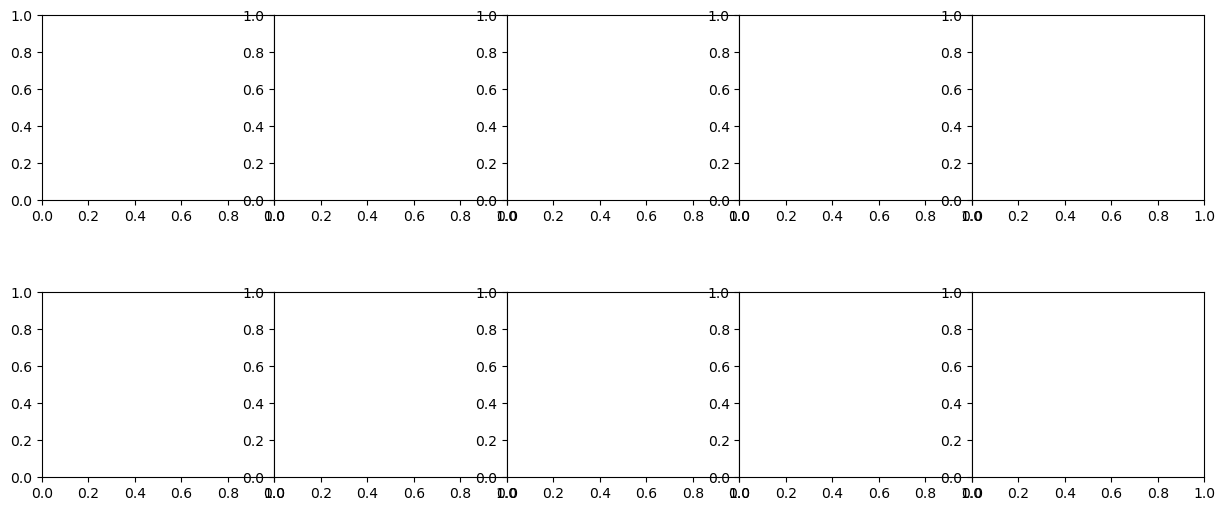

In [15]:
autoencoder.eval()

def interpolation(lambda1, model, img1, img2):
    with torch.no_grad():
        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)

        latent_with_lambda = []
        for i,(latent_1,latent_2) in enumerate(zip(latent_1, latent_2)):
            
            # # interpolation of the two latent vectors
            latent_lambda = (1 - lambda1) * latent_1 + (lambda1) * latent_2
            latent_with_lambda.append(latent_lambda)

        # reconstruct interpolated image
        inter_image = model.decoder(latent_with_lambda[-1],latent_with_lambda[0],latent_with_lambda[1],latent_with_lambda[2],latent_with_lambda[3])
        inter_image = inter_image.cpu()
    
    return inter_image
    

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

# We start off by taking two images from the dataset, and linearly interpolate between them
for ind,l in enumerate(lambda_range):
    inter_image = interpolation(float(l), autoencoder, Images[20], Images[25])
    inter_image = to_img(inter_image)
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show() 

Random Latent Vector - generating random images
-------------------------------------------------

Typically, new images are generated using random points in the latent space. Taken a step further, points in the latent space can be constructed (e.g. all 0s, all 0.5s, or all 1s) and used as input or a query to generate a specific image.

We are going to transform our latent space by using simple vector arithmetic to create new points in the latent space that, in turn, can be used to generate images. This is an interesting idea, as it allows for the intuitive and targeted generation of images.


In [ ]:
# autoencoder.eval()

# with torch.no_grad():
#     # approx. fit a multivariate Normal distribution (with diagonal cov.) to the latent vectors of a random part of the test set
#     images, labels = next(iter(test_dataloader))
#     images = images.to(device)
#     latent = autoencoder.encoder(images)
#     latent = latent.cpu()

#     # Finding the mean and standard deviation from our latent space
#     mean = latent.mean(dim=0)
#     std = (latent - mean).pow(2).mean(dim=0).sqrt()

#     # sample latent vectors from the normal distribution
#     latent = torch.randn(latent.shape[0], latent.shape[1])*std + mean

#     # reconstruct images from the latent vectors
#     latent = latent.to(device)
#     img_recon = autoencoder.decoder(latent)
#     img_recon = img_recon.cpu()

#     fig, ax = plt.subplots(figsize=(5, 5))
#     show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
#     plt.show()

In [ ]:
#  latent = torch.randn(128, num_classes)*std + mean
#  latent